In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re

In [2]:
def dataCleaning(rnwkgus_Books):
    # NaN인 열 삭제
    rnwkgus_Books = rnwkgus_Books.dropna(axis=1, how='all')

    # 대출건수를 합치기 위해 필요한 행만 추출하여 새로운 데이터프레임을 만든다.
    count = rnwkgus_Books[['도서명','저자','ISBN','권','대출건수']]

    # 도서명, 저자, ISBN, 권을 기준으로 대출건수를 그룹한다.
    loacCount = count.groupby(by=['도서명','ISBN','권'],dropna=False).sum() 
    
    # 도서명, 저자, ISBN, 권을 기준으로 중복된 행을 True로 표기한다.
    dupRows = rnwkgus_Books.duplicated(subset=['도서명','저자','ISBN','권'])

    # 불리언 배열을 반전시켜 고유한 행을 True로 표시하다.
    uniqueRows = ~dupRows

    # 고유한 행을 새로운 데이터프레임으로 만든다.
    rnwkgus_Books2 = rnwkgus_Books[uniqueRows]

    # 도서명, 저자, ISBN, 권을 인덱스로 지정한다.
    rnwkgus_Books2.set_index(['도서명','저자','ISBN','권'],inplace=True)

    # 원본 데이터프레임을 업데이트
    rnwkgus_Books2.update(loacCount)

    # 데이터프레임 인덱스를 재설정
    rnwkgus_Books3 = rnwkgus_Books2.reset_index()

    # 원래 열을 순서대로 맟춘다
    rnwkgus_Books3 = rnwkgus_Books3[rnwkgus_Books.columns]

    # 결과를 반환한다.
    return rnwkgus_Books3

def getBookInfo(row):
    title = row['도서명']
    author = row['저자']
    pub = row['출판사']
    year = row['발행년도']
    isbn = row['ISBN']
    # Yes24 도서 검색 페이지 URL을 포맷팅한다.
    url = f'http://www.yes24.com/Product/Search?domain=BOOK&query={isbn}' 

    # URL 페이지의 HTML을 가져온다.
    r = requests.get(url)

    # 가져온 HTML을 파싱한다.
    html = BeautifulSoup(r.text, 'html.parser')

    # title이 NaN이면 HTML에서 title 값을 찾아 채워 넣는다.
    try:
        if pd.isna(title):
            title = html.find('a', attrs={'class':'gd_name'}).get_text()
    except AttributeError:
        pass

    # author이 NaN이면 HTML에서 author 값을 찾아 채워 넣는다.
    try:
        if pd.isna(author):
            authors = html.find('span', attrs={'class':'info_auth'}).find_all('a') 
            author = list(tag.get_text() for tag in authors) 
    except AttributeError:
        pass

    # pub이 NaN이면 HTML에서 pub 값을 찾아 채워 넣는다.
    try:
        if pd.isna(pub):
            pub = html.find('span', attrs={'class':'info_pub'}).find('a').get_text()
    except AttributeError:
        pass

    # year이 -1이면 HTML에서 year 값을 찾아 채워 넣는다.
    try:
        if year == -1:
            year_str = html.find('span', attrs={'class':'info_date'}).get_text()
            year = re.findall(r'\d{4}', year_str)[0]
    except AttributeError:
        pass

    # 결과를 반환한다.
    return title,author,pub,year

def dataFixing(rnwkgus_Books3):
    # 도서권수와 대출건수를 int32로 변환한다. 
    rnwkgus_Books3 = rnwkgus_Books3.astype({'도서권수':'int32', '대출건수':'int32'})

    # NaN인 세트 ISBN을 빈 문자열로 변환한다.
    set_isbn_na_rows = rnwkgus_Books3['세트 ISBN'].isna()
    rnwkgus_Books3.loc[set_isbn_na_rows, '세트 ISBN'] = ''

    # 발행년도 열에서 연도 네자리를 추출하여 대체한다.
    rnwkgus_Books4 = rnwkgus_Books3.replace({'발행년도':{r'.*(\d{4}).*'}}, r'\1', regex=True)
    unkown_year = rnwkgus_Books4['발행년도'].str.contains('\D', na=True)

    # 나머지 발행년도는 -1로 변환한다.
    rnwkgus_Books4.loc[unkown_year, '발행년도'] = '-1'

    # 발행년도를 int32로 변환한다.
    rnwkgus_Books4 = rnwkgus_Books4.astype({'발행년도': 'int32'})

    # 발행년도가 4000년 이상인 경우 2333년을 뺀다
    dangun_yy_rows = rnwkgus_Books4['발행년도'].gt(4000)
    rnwkgus_Books4.loc[dangun_yy_rows, '발행년도'] = rnwkgus_Books4.loc[dangun_yy_rows, '발행년도'] - 2333

    # 여전히 발행년도가 4000년 이상인 경우 -1로 변환한다.
    dangun_year = rnwkgus_Books4['발행년도'].gt(4000)
    rnwkgus_Books4.loc[dangun_year, '발행년도'] = -1

    # 발행년도가 0 ~ 1900년 사이인 경우 발행년도를 -1로 변환한다.
    old_books = rnwkgus_Books4['발행년도'].gt(0) & rnwkgus_Books4['발행년도'].lt(1900)
    rnwkgus_Books4.loc[old_books, '발행년도'] = -1
    
    # 도서명, 저자, 출판사가 NaN이거나 발행년도가 -1인 행을 추출한다.
    na_rows = rnwkgus_Books4['도서명'].isna() | rnwkgus_Books4['저자'].isna() | rnwkgus_Books4['출판사'].isna() | rnwkgus_Books4['발행년도'].eq(-1)

    # Yes24 도서 상세 페이지에서 누락된 정보를 채운다.
    updated_sample = rnwkgus_Books4[na_rows].apply(getBookInfo, axis=1, result_type='expand')

    # 칼럼명을 도서명, 저자, 출판사, 발행년도로 변경한다
    updated_sample.columns = ['도서명', '저자', '출판사', '발행년도']

    # ns_book5 데이터 프레임을 업데이트한다.
    rnwkgus_Books4.update(updated_sample, overwrite=True)

    # 도서명, 저자, 출판사가 NaN이거나 발행년도가 -1인 행을 삭제한다.
    rnwkgus_Books5 = rnwkgus_Books4.dropna(subset=['도서명', '저자', '출판사'])
    rnwkgus_Books5 = rnwkgus_Books5[rnwkgus_Books5['발행년도'] != -1]

    return rnwkgus_Books5 # 결과를 반환한다.

def final_BookDataAnalysis(fileName):
    # csv 파일을 데이터프레임으로 읽어온다.
    rnwkgus_Books = pd.read_csv(f'{fileName}', encoding='EUC-KR', low_memory=False)
    
    # dataCleaning() 함수로 데이터를 전처리한다.
    rnwkgus_Books3 = dataCleaning(rnwkgus_Books)

    # dataFixing() 함수로 잘못된 값을 수정하거나 NaN을 채운다.
    rnwkgus_Books6 = dataFixing(rnwkgus_Books3)

    # 최종 결과를 반환한다.
    return rnwkgus_Books6

# final_BookDataAnalysis() 함수로 데이터를 분석한 결과를 반환받는다.
finalData = final_BookDataAnalysis('강남구립논현도서관 장서 대출목록 (2023년 03월).csv')

# 최종 데이터 프레임 출력
finalData

,번호,도서명,저자,출판사,발행년도,ISBN,세트 ISBN,부가기호,권,주제분류번호,도서권수,대출건수,등록일자
0,1,잡아라 초6 골든타임 =,김승태 지음,책이라는신화,2022,9791197749933,,7,2,082,1,0,2023-03-20
1,2,잡아라 초6 골든타임 =,정창훈 지음,책이라는 신화,2022,9791197749926,,7,1,082,1,0,2023-03-20
2,3,매직 엘리베이터 =,노지영 글,아울북,2022,9788950942854,,7,9,404,1,0,2023-03-20
3,4,클래식 음악의 괴짜들 =,스티븐 이설리스 글,비룡소,2010,9788949187099,,4,1,670.99,1,0,2023-03-20
4,5,흔적을 지워드립니다 = : 특수청소 전문회사 데드모닝,마에카와 호마레 지음 이수은 옮김,라곰,2022,9791189686543,,0,NaN,833.6,1,0,2023-03-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51766,52137,하프 턴,서유진 지음,문예바다,2015,9791185407425,,0,NaN,813.6,1,0,1970-01-01
51767,52138,(엣센스)한자사전 = 실용옥편,민중서립 편집부 [편] 지음,民衆書林,1999,9788938701336,,NaN,NaN,713.02,1,0,1970-01-01
51768,52139,한국 축구 발전사,김성원 지음,살림출판사,2006,9788952204998,,NaN,NaN,080,1,0,1970-01-01
51769,52140,소유 하,앤토니어 수잔 바이어트 지음.윤희기 옮김,미래사,2003,9788970872728,9788970872704.0,NaN,NaN,843,1,0,1970-01-01


In [51]:
finalData2 = finalData['발행년도'].astype('int32')
finalData2

0        2022
1        2022
2        2022
3        2010
4        2022
         ... 
51766    2015
51767    1999
51768    2006
51769    2003
51770    2008
Name: 발행년도, Length: 51671, dtype: int32

In [52]:
finalData3 = finalData2[(finalData2 >= 2000) & (finalData2 <= 2023)]
finalData3

0        2022
1        2022
2        2022
3        2010
4        2022
         ... 
51765    2017
51766    2015
51768    2006
51769    2003
51770    2008
Name: 발행년도, Length: 50509, dtype: int32

In [53]:
finalData4 = finalData3.drop_duplicates(keep='first', inplace=False)
finalData4

0       2022
3       2010
5       2023
21      2015
27      2020
38      2013
67      2019
72      2018
77      2021
155     2017
162     2009
200     2016
266     2014
298     2008
299     2006
409     2001
531     2011
549     2007
553     2012
769     2003
1013    2005
1821    2004
3289    2002
3424    2000
Name: 발행년도, dtype: int32

In [54]:
year = finalData4.sort_values()
year

3424    2000
409     2001
3289    2002
769     2003
1821    2004
1013    2005
299     2006
549     2007
298     2008
162     2009
3       2010
531     2011
553     2012
38      2013
266     2014
21      2015
200     2016
155     2017
72      2018
67      2019
27      2020
77      2021
0       2022
5       2023
Name: 발행년도, dtype: int32

In [70]:
loansCount = []

datas = finalData.astype({'발행년도':'int32'})

for i in year:
    data = datas[datas['발행년도'] == i]
    loansCount.append(data['대출건수'].sum())

loansCount

[4882,
 5044,
 4799,
 10175,
 15048,
 9288,
 15799,
 24050,
 58488,
 25974,
 18320,
 21084,
 33251,
 37963,
 36191,
 34988,
 36230,
 35180,
 26791,
 24513,
 21659,
 21846,
 11712,
 9]

In [72]:
bookCount = []

for i in year:
    data = datas[datas['발행년도'] == i]
    bookCount.append(data['도서권수'].sum())

bookCount

[437,
 654,
 549,
 983,
 1294,
 1115,
 1945,
 2487,
 4762,
 2624,
 1615,
 1793,
 2438,
 2565,
 2238,
 2146,
 2405,
 2799,
 2680,
 3377,
 3549,
 3866,
 3228,
 53]

In [76]:
print('len(year) == len(loansCount) :', len(year) == len(loansCount), '\n')
yearList = list(year)
loansCountList = list(loansCount)
bookCountList = list(bookCount)

print('발행년도 대출건수 도서권수')
for i in range(0, len(year)):
    print(yearList[i], loansCountList[i], bookCountList[i])

len(year) == len(loansCount) : True 

발행년도 대출건수 도서권수
2000 4882 437
2001 5044 654
2002 4799 549
2003 10175 983
2004 15048 1294
2005 9288 1115
2006 15799 1945
2007 24050 2487
2008 58488 4762
2009 25974 2624
2010 18320 1615
2011 21084 1793
2012 33251 2438
2013 37963 2565
2014 36191 2238
2015 34988 2146
2016 36230 2405
2017 35180 2799
2018 26791 2680
2019 24513 3377
2020 21659 3549
2021 21846 3866
2022 11712 3228
2023 9 53


C:\Users\g8808\AppData\Local\Temp\ipykernel_19208\3111446459.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


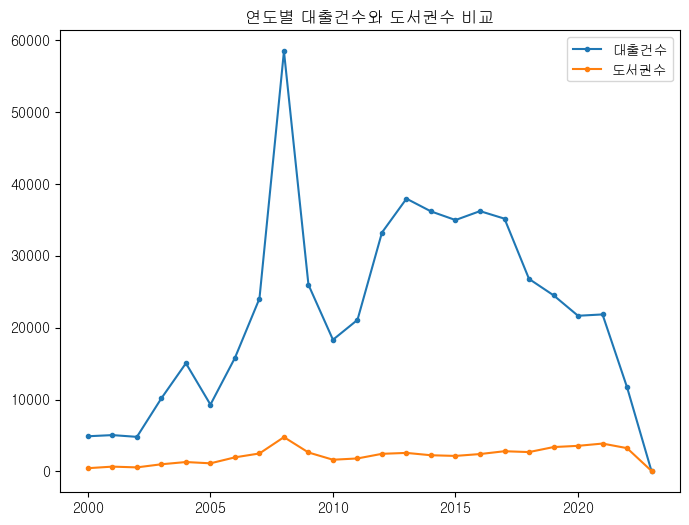

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(year, loansCountList, label='대출건수', marker='.')
ax.plot(year, bookCountList, label='도서권수', marker='.')
ax.set_title('연도별 대출건수와 도서권수 비교')
ax.legend()
fig.show()